# In this file we calibrate the rough Heston model through the direct MLP image based random grids approach
This is a one-step approach meaning that we don't go through the forward pass where we learn the **mapping** between **rough Heston parameters** and the entire implied volatility **surface**, which in this case is on an adaptive random grid 11(maturities)x13(strikes). Instead here we train the network only for the calibration purpose, switching input and output in the forward pass, this way we can immediately perform the calibration with a single evalutaion of the network: no posterior optimization required.
Below we upload the dataset .

In [1]:
#Set the directory of stored dataset
import os
os.chdir("C:/Users/pc/Desktop/politecnico/TESI/mio codice/rHeston/random grids")

In [3]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
#Open compressed dataset

file_path = "rHestonflatRandomGridsDataset.csv"
df=pd.read_csv(file_path) #load data in a numpy array
clean_data = df.iloc[:, :6].values
xx = df.iloc[:, :4].values   #extract first 4 columns (rHeston parameters)
clean_ivs = df.iloc[:, 6].values

print("\nInput (rough rHeston parameter sets) shape (samples × 4 parameters):", xx.shape)
print("  - Each row contains: [H, γ, ρ, ν₀]")
print("\nShape clean_data:", clean_data.shape)  # Should be (19994*143, 6)
print("\nShape clean_ivs:", clean_ivs.shape)    # Should be (19994*143,)
print("\nFirst 3 rows of clean data:")
print(clean_data[:3])
print("\nFirst 3 implied vols:")
print(clean_ivs[:3])


Input (rough rHeston parameter sets) shape (samples × 4 parameters): (2288000, 4)
  - Each row contains: [H, γ, ρ, ν₀]

Shape clean_data: (2288000, 6)

Shape clean_ivs: (2288000,)

First 3 rows of clean data:
[[ 0.09988963  0.62535715 -0.26080363  0.07983231  0.9432724   0.01311258]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.96101277  0.01311258]
 [ 0.09988963  0.62535715 -0.26080363  0.07983231  0.96635666  0.01311258]]

First 3 implied vols:
[0.34896368 0.31626087 0.30632921]


# Let's have a look at the dataset and gain some more informations


=== HESTON PARAMETERS ANALYSIS (xx) ===
       H (Hurst exponent)  ν (vol of variance)  ρ (spot-vol correlation)  \
count          16000.0000           16000.0000                16000.0000   
mean               0.1299               0.3987                   -0.3999   
std                0.0691               0.1441                    0.1726   
min                0.0100               0.1500                   -0.7000   
1%                 0.0122               0.1555                   -0.6938   
5%                 0.0224               0.1756                   -0.6697   
50%                0.1299               0.3990                   -0.4000   
95%                0.2375               0.6240                   -0.1305   
99%                0.2474               0.6450                   -0.1066   
max                0.2500               0.6499                   -0.1000   

       ν₀ (initial variance)  
count             16000.0000  
mean                  0.0677  
std                   0.0362 

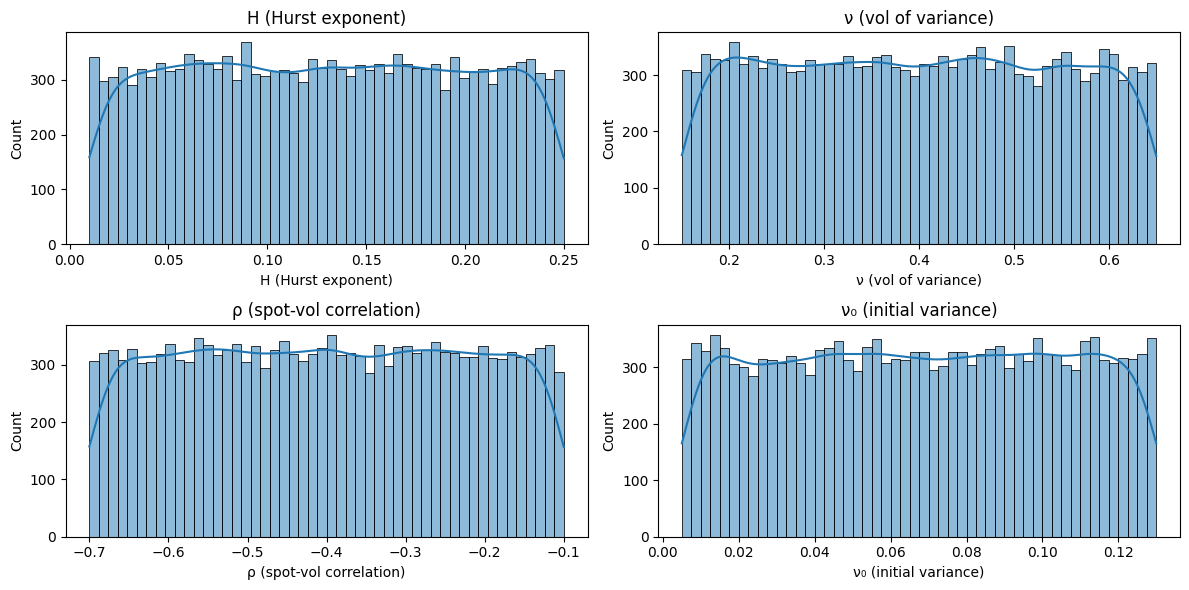

Global mean: 0.2505
Global min: 0.0260
Global max: 0.5895


In [4]:
import seaborn as sns

#INPUT (rHESTON PARAMETERS) ANALYSIS 

# rHeston parameter names (for clarity)
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

param_names = [
    'H (Hurst exponent)',
    'ν (vol of variance)',
    'ρ (spot-vol correlation)',
    'ν₀ (initial variance)'
]


# Create DataFrame for statistical analysis
df_xx = pd.DataFrame(xx[::143,:], columns=param_names)

# Descriptive statistics
print("\n=== HESTON PARAMETERS ANALYSIS (xx) ===")
print(df_xx.describe(percentiles=[0.01, 0.05, 0.95, 0.99]).round(4))

# Validate physical bounds
print("\n=== PHYSICAL BOUNDS ===")
print(f"ν₀:    Min={df_xx.iloc[:,3].min():.4f}, Max={df_xx.iloc[:,3].max():.4f} (Expected: ~[0.005, 0.13])")
print(f"ρ:   Min={df_xx.iloc[:,2].min():.4f}, Max={df_xx.iloc[:,2].max():.4f} (Expected: ~[-0.7, -0.1])")
print(f"H: Min={df_xx.iloc[:,0].min():.4f}, Max={df_xx.iloc[:,0].max():.4f} (Expected: ~[0.01, 0.25])")

# Plot distributions
plt.figure(figsize=(12, 6))
for i, col in enumerate(df_xx.columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(df_xx[col], bins=50, kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Global statistics
print(f"Global mean: {clean_ivs.mean():.4f}")
print(f"Global min: {clean_ivs.min():.4f}")
print(f"Global max: {clean_ivs.max():.4f}")

# Train-val-test split
In the following snippet we perform the usual trainining-validation-test split, but we need to be careful, this split is not completely random. In fact we need to handle the dataset not at a single-option level, but to parameter set level, meaning that we need to **preserve the integrity** of each surface referring to a parameter set, ESPECIALLY on the test set, where we will calibrate each IV surface.

In [5]:
def split_parameter_blocks(X_pw, y_pw, points_per_sample=143, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    """
    Splits the dataset into train/val/test sets while keeping all strike-maturity combinations
    for each Heston parameter set together (no mixing of parameter sets across splits).
    
    Args:
        X_pw: Pointwise features array (n_samples*n_points, 6) [H, γ, ρ, ν₀ ,strike,maturity]
        y_pw: Pointwise target array (n_samples*n_points,) [implied_vols]
        points_per_sample: Number of points per parameter set (default 143)
        train_ratio: Fraction of parameter sets for training
        val_ratio: Fraction of parameter sets for validation
        test_ratio: Fraction of parameter sets for testing
        random_seed: Optional random seed for reproducibility
        
    Returns:
        Tuple of (X_train, y_train), (X_val, y_val), (X_test, y_test)
    """
    # Verify ratios sum to 1
    assert np.isclose(train_ratio + val_ratio + test_ratio, 1.0), "Ratios must sum to 1"
    
    # Calculate number of unique parameter sets
    n_samples = len(X_pw) // points_per_sample
    assert len(X_pw) == n_samples * points_per_sample, "Data length doesn't match expected samples*points"
    
    print(f"Total parameter sets: {n_samples}")
    print(f"Points per parameter set: {points_per_sample}")
    print(f"Total points: {len(X_pw)}")
    
    # Create sample indices (0,0,0..., 1,1,1..., etc.)
    sample_indices = np.repeat(np.arange(n_samples), points_per_sample)
    
    # Split parameter set indices (not the points themselves)
    np.random.seed(random_seed)
    shuffled_indices = np.random.permutation(n_samples)
    
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    train_samples = shuffled_indices[:train_end]
    val_samples = shuffled_indices[train_end:val_end]
    test_samples = shuffled_indices[val_end:]
    
    print(f"\nSplit counts:")
    print(f"Training parameter sets: {len(train_samples)} ({len(train_samples)/n_samples:.1%})")
    print(f"Validation parameter sets: {len(val_samples)} ({len(val_samples)/n_samples:.1%})")
    print(f"Test parameter sets: {len(test_samples)} ({len(test_samples)/n_samples:.1%})")
    
    # Create masks for each split
    train_mask = np.isin(sample_indices, train_samples)
    val_mask = np.isin(sample_indices, val_samples)
    test_mask = np.isin(sample_indices, test_samples)
    
    # Apply masks to get splits
    X_train, y_train = X_pw[train_mask], y_pw[train_mask]
    X_val, y_val = X_pw[val_mask], y_pw[val_mask]
    X_test, y_test = X_pw[test_mask], y_pw[test_mask]
    
    # Verification checks
    assert len(X_train) == len(train_samples) * points_per_sample
    assert len(X_val) == len(val_samples) * points_per_sample
    assert len(X_test) == len(test_samples) * points_per_sample
    
    # Verify no overlapping parameter sets between splits
    assert len(set(train_samples) & set(val_samples)) == 0
    assert len(set(train_samples) & set(test_samples)) == 0
    assert len(set(val_samples) & set(test_samples)) == 0
    
    print("\nVerification passed - all parameter sets remain intact in their respective splits")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test)


# Example usage:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = \
    split_parameter_blocks(clean_data, clean_ivs, points_per_sample=143,
                          train_ratio=0.8, val_ratio=0.1, test_ratio=0.1,
                          random_seed=42)

# Verification prints
print("\n=== Split Shapes ===")
print(f"Training set: {X_train.shape} (should be ~{len(clean_data)*0.8:.0f} points)")
print(f"Validation set: {X_val.shape} (should be ~{len(clean_data)*0.1:.0f} points)")
print(f"Test set: {X_test.shape} (should be ~{len(clean_data)*0.1:.0f} points)")

print("\n=== Sample Distribution ===")
print(f"First training sample params: {X_train[0][:4]}")
print(f"First validation sample params: {X_val[0][:4]}")
print(f"First test sample params: {X_test[0][:4]}")

Total parameter sets: 16000
Points per parameter set: 143
Total points: 2288000

Split counts:
Training parameter sets: 12800 (80.0%)
Validation parameter sets: 1600 (10.0%)
Test parameter sets: 1600 (10.0%)

Verification passed - all parameter sets remain intact in their respective splits

=== Split Shapes ===
Training set: (1830400, 6) (should be ~1830400 points)
Validation set: (228800, 6) (should be ~228800 points)
Test set: (228800, 6) (should be ~228800 points)

=== Sample Distribution ===
First training sample params: [ 0.09988963  0.62535715 -0.26080363  0.07983231]
First validation sample params: [ 0.04744447  0.22799726 -0.66514983  0.11327202]
First test sample params: [ 0.08301814  0.41237822 -0.44083299  0.04140364]


# Scaling:
Now we can finally scale both the parameters as shown below and the implied volatilities, this will improve the numerical stability of the training and calibration procedure.

# Output Model Parameters ${\theta}_{i=1,..,4}\to scale(\theta_i)\in[-1,1]$ (suitable for tanh activation)
## $scale(\theta_i)=\frac{2\theta_i-(\theta_i^{max}+\theta_i^{min})}{\theta_i^{max}-\theta_i^{min}},\quad i \in |\Theta|$

# Implied volatilities input scaling:
## $$scale(\sigma^{BS}_{i,j})=\frac{\sigma^{BS}_{i,j}-\mathbb{E}[\sigma^{BS}_{i,j}]}{std(\sigma^{BS}_{i,j})},\quad i\in\text{Maturities},\; j\in \text{Strikes}$$
Remember that we don't scale strikes and maturities grids in input

In [6]:
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate

# =================================================================
# 1. IMPLIED VOLATILITY SCALING (StandardScaler)
# =================================================================
scaler_yy = StandardScaler()

# Reshape y arrays to 2D if needed (StandardScaler expects 2D input)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Apply scaling
y_train_transform = scaler_yy.fit_transform(y_train)  # Compute μ and σ on training set
y_val_transform = scaler_yy.transform(y_val)          # Use same μ and σ
y_test_transform = scaler_yy.transform(y_test)        # Use same μ and σ

# Inverse transform function
def yinversetransform(y_scaled):
    """Convert scaled volatilities back to original scale"""
    return scaler_yy.inverse_transform(y_scaled)

# ========================================================================
#2-Custom [-1,1] rHeston parameter scaling, define rHeston parameter's upper and lower bounds
# ===============================================================================
#H     ∈ [0.01, 0.25]        (Hurst exponent)
#ν     ∈ [0.15, 0.65]        (initial variance)
#ρ     ∈ [-0.7, -0.1]        (spot-vol correlation)
#ν₀    ∈ [0.005, 0.13]       (vol of variance)

#parameters order is: [H, ν, ρ, ν₀]

ub=np.array([0.25,0.65,-0.1,0.13])
lb=np.array([0.01,0.15,-0.7,0.005])

def myscale(x):
    """
    Scale rHeston parameters to [-1,1] range while preserving strike/maturity
    Args:
        x: Input array (n_points, 6) where cols 0-3 are rHeston params, 4-5 are strike/maturity
    Returns:
        Scaled array with same shape, only rHeston params transformed
    """
    x_scaled = x.copy()
    # Only scale first 4 columns (rHeston params)
    for i in range(4):
        x_scaled[:,i] = (2*x[:,i] - (ub[i] + lb[i])) / (ub[i] - lb[i])
    return x_scaled

def myinverse(x_scaled):
    """
    Convert scaled rHeston params back to original scale
    Args:
        x_scaled: Scaled array (n_points, 6)
    Returns:
        Array with rHeston params in original scale
    """
    x_original = x_scaled.copy()
    for i in range(4):
        x_original[:,i] = x_scaled[:,i] * (ub[i] - lb[i]) * 0.5  + (ub[i] + lb[i])*0.5
    return x_original

# Apply scaling (only to rHeston params, leave strike/maturity unchanged)
x_train_transform = myscale(X_train)
x_val_transform = myscale(X_val)
x_test_transform = myscale(X_test)

# =================================================================
# VERIFICATION
# =================================================================
def verify_scaling(original, scaled, param_names):
    """Check scaling was correctly applied"""
    print("\nScaling verification for:", param_names)
    for i in range(4):  # Only check rHeston params
        orig_min, orig_max = original[:,i].min(), original[:,i].max()
        scaled_min, scaled_max = scaled[:,i].min(), scaled[:,i].max()
        print(f"{param_names[i]:<6}: [{orig_min:.4f},{orig_max:.4f}] -> [{scaled_min:.4f},{scaled_max:.4f}]")
    
    # Verify strike/maturity unchanged
    assert np.allclose(original[:,4:], scaled[:,4:]), "Strike/maturity values were modified!"

print("=== Scaling Verification ===")
verify_scaling(X_train, x_train_transform, ["H", "ν", "ρ", "ν₀"])

# =================================================================
# DATASET SUMMARY
# =================================================================
shape_data = [
    ["Training", x_train_transform.shape, y_train_transform.shape],
    ["Validation", x_val_transform.shape, y_val_transform.shape], 
    ["Test", x_test_transform.shape, y_test_transform.shape]
]

print("\n=== Scaled Dataset Shapes ===")
print(tabulate(shape_data,
               headers=["Split", "Features Shape", "Target Shape"],
               tablefmt="grid",
               stralign="center"))

print("\nKey Notes:")
print("- Only rHeston parameters (first 4 columns) were scaled to [-1,1] range")
print("- Strike and maturity values (last 2 columns) remain in original scale")
print("- Implied volatilities were standardized using z-score scaling")

=== Scaling Verification ===

Scaling verification for: ['H', 'ν', 'ρ', 'ν₀']
H     : [0.0100,0.2500] -> [-0.9998,0.9999]
ν     : [0.1500,0.6499] -> [-0.9999,0.9995]
ρ     : [-0.7000,-0.1000] -> [-1.0000,0.9999]
ν₀    : [0.0050,0.1300] -> [-1.0000,0.9998]

=== Scaled Dataset Shapes ===
+------------+------------------+----------------+
|   Split    |  Features Shape  |  Target Shape  |
+============+==================+================+
|  Training  |   (1830400, 6)   |  (1830400, 1)  |
+------------+------------------+----------------+
| Validation |   (228800, 6)    |  (228800, 1)   |
+------------+------------------+----------------+
|    Test    |   (228800, 6)    |  (228800, 1)   |
+------------+------------------+----------------+

Key Notes:
- Only rHeston parameters (first 4 columns) were scaled to [-1,1] range
- Strike and maturity values (last 2 columns) remain in original scale
- Implied volatilities were standardized using z-score scaling


# Reshape the surfaces
Below we reshape the implied volatility surfaces, the strikes and the maturities into triplets order to make them suitable for the MLP

## **Inputs:**
### vector of dimension: (143*3,), the triplets are:
###  1. $\sigma^{BS}_{i,j}$ implied volatility surface (11x13)
###  2. $K_{i,j}$ strikes grid  (11x13)
###  3. $T_i$ maturities (11, repeated 13 times along rows)

## **Outputs:** 
###  1. $H$ Hurst exponent
###  2. $\nu$ vol of vol
###  3. $\rho$ spot-vol correlation
###  4. $\nu_{0}$ inital variance

In [7]:
def reshape_for_mlp_triplet(X, y, n_maturities=11, n_strikes=13):
    """
    Reshape random grid data into flattened format for MLP.
    Each surface is represented as a vector of length 429 = 143 * 3,
    where each triplet is [vol, strike, maturity].
    
    Args:
        X: (N*143, 6) array (rHeston params + strike + maturity)
        y: (N*143,) or (N*143,1) array (implied volatilities)
    Returns:
        X_mlp: (N, 429) input for MLP
        y_mlp: (N, 4) rHeston parameters
    """
    # Flatten y to shape (N*143,)
    y = y.reshape(-1)

    # Compute number of surfaces
    n_options = n_maturities * n_strikes
    N = X.shape[0] // n_options
    assert X.shape[0] % n_options == 0, "Mismatch: total rows not divisible by 143"

    # Reshape in groups
    X_reshaped = X.reshape(N, n_options, 6)
    y_reshaped = y.reshape(N, n_options)

    # Extract strikes, maturities, vols
    strikes = X_reshaped[:, :, 4]      # (N, 143)
    maturities = X_reshaped[:, :, 5]   # (N, 143)
    vols = y_reshaped                  # (N, 143)

    # Build triplets [vol, strike, maturity] for each option
    triplets = np.stack([vols, strikes, maturities], axis=-1)  # (N, 143, 3)

    # Flatten into (N, 429)
    X_mlp = triplets.reshape(N, -1)

    # Extract rHeston parameters (same for all points in a surface)
    y_mlp = X_reshaped[:, 0, :4]

    return X_mlp, y_mlp

# Apply transformation to every set
X_train_mlp, y_train_mlp = reshape_for_mlp_triplet(X_train, y_train)
X_val_mlp, y_val_mlp = reshape_for_mlp_triplet(X_val, y_val)
X_test_mlp, y_test_mlp = reshape_for_mlp_triplet(X_test, y_test)

# Scaled verision
X_train_mlp_transform, y_train_mlp_transform = reshape_for_mlp_triplet(x_train_transform, y_train_transform)
X_val_mlp_transform, y_val_mlp_transform = reshape_for_mlp_triplet(x_val_transform, y_val_transform)
X_test_mlp_transform, y_test_mlp_transform = reshape_for_mlp_triplet(x_test_transform, y_test_transform)

# Check shapes
print("Training:", X_train_mlp.shape, y_train_mlp.shape)
print("Validation:", X_val_mlp.shape, y_val_mlp.shape)
print("Test:", X_test_mlp.shape, y_test_mlp.shape)
print("First training triplet: ",X_train_mlp[0,:3])
print("First scaled training triplet: ",X_train_mlp_transform[0,:3])
print("First scaled training parameters: ",y_train_mlp_transform[0,:])

Training: (12800, 429) (12800, 4)
Validation: (1600, 429) (1600, 4)
Test: (1600, 429) (1600, 4)
First training triplet:  [0.34896368 0.9432724  0.01311258]
First scaled training triplet:  [1.16920583 0.9432724  0.01311258]
First scaled training parameters:  [-0.25091976  0.90142861  0.46398788  0.19731697]


# CaNN: Calibration Neural Network
Now we can directly train the network to **calibrate** the rHeston parameters, learning the mapping from: [implied volatility surface, strikes grid, maturities grid] -> rHeston parameters. We can set up our neural network composed of:

- **4 hidden layers**, each with **30 neurons**  
- **output layer** with 4 neurons (parameters space dimension), here we select a **tanh** activation function since we scaled the parameters into [-1,1] interval
- **Activation function**: **Elu** , $\sigma_{Elu}=\alpha(e^x -1)$ in all the layers, its smoothness is crucial for the approximation of the Loss function
- **Batch size**: **256**  
- **Optimizer**: **Adam**  
- **Early stopping**: with patience set to 40 epochs
- **Loss**: MSE

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers


# Set precision to float64
tf.keras.backend.set_floatx('float64')
tf.random.set_seed(42)  # For consistent initialization

# Build the model
inputs = Input(shape=(429,), name='input_layer')
x = Dense(30, activation='elu')(inputs)
x = Dense(30, activation='elu')(x)
x = Dense(30, activation='elu')(x)
x = Dense(30, activation='elu')(x)
outputs = Dense(4, activation='tanh')(x)
model_mlp = Model(inputs, outputs)

model_mlp = Model(inputs=inputs, outputs=outputs, name='mlp_random_grids')
model_mlp.summary()

Model: "mlp_random_grids"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 429)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 4)              │           124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,814 (123.55 KB)

 Trainable params: 15,814 (123.55 KB)

 Non-trainable params: 0 (0.00 B)

**Train the model**

Epoch 1/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0500 - val_loss: 0.0090
Epoch 2/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0077
Epoch 3/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0080
Epoch 4/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0079
Epoch 5/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0081
Epoch 6/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0083
Epoch 7/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 8/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0081
Epoch 9/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0082
Epoch 10/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0082
Epoch 11/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0068 - val_loss: 0.0080
Epoch 12/400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

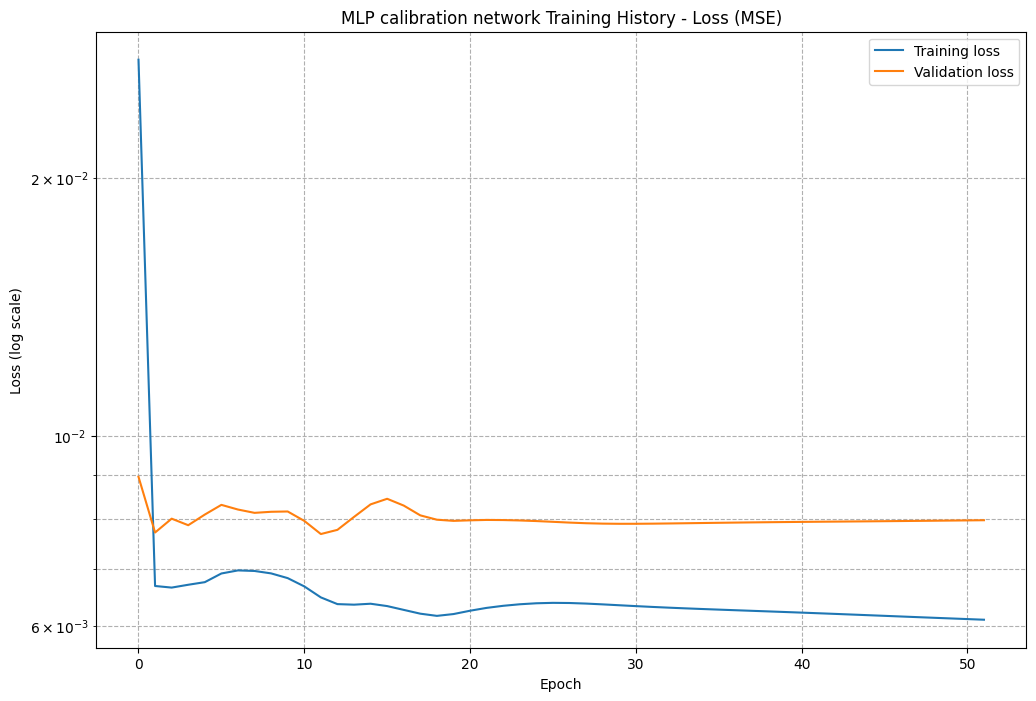


Final Training Loss: 6.1005e-03
Final Validation Loss: 7.9714e-03


In [11]:
import time

# EarlyStopping callback
earlystop = EarlyStopping(
    monitor='val_loss', 
    patience=40,       
    verbose=1,       
    restore_best_weights=True  # Restore the best model weights
)

# Callbacks
#reduce_lr = ReduceLROnPlateau(
#        monitor='val_loss',
#        factor=0.5,
#        patience=20,
#        min_lr=5e-5,
 #       verbose=1
 #   )

# Compile the model
model_mlp.compile(loss="mse", optimizer="adam")

# Train the model
start=time.time()
history = model_mlp.fit(
    X_train_mlp_transform, 
    y_train_mlp_transform, 
    batch_size=256,
    validation_data=(X_val_mlp_transform, y_val_mlp_transform),
    epochs=400, 
    verbose=1, 
    shuffle=True, 
    callbacks=[earlystop]
)
end=time.time()
training_time=(end-start)
print("Training time :" ,training_time , "s" )

# Plot training history
plt.figure(figsize=(12, 8))  
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.yscale('log')
plt.title('MLP calibration network Training History - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (log scale)')
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

# Print final metrics
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print(f"\nFinal Training Loss: {final_train_loss:.4e}")
print(f"Final Validation Loss: {final_val_loss:.4e}")

# Evaluate the calibration network on test data
We can already assess the performance of the calibration network, in fact since it's been trained on implied volatility surfaces, it's possible to assess the calibration performance on test data.

In [12]:
# Calculate predictions on scaled test implied volatility surfaces+strikes+maturities
start=time.perf_counter()
y_pred_transformed = model_mlp.predict(X_test_mlp_transform)
calib_time = (time.perf_counter()-start)/X_test_mlp.shape[0]
print("Calibration time (per surface):" , calib_time*1000 , "ms" )

# 1) Error on preprocessed test parameters (y_test_transform)
mse_transformed = np.mean(np.square(y_test_mlp_transform - y_pred_transformed))
rmse_transformed = np.sqrt(mse_transformed)

print("\nErrors on preprocessed test data:")
print(f"- MSE: {mse_transformed:.6f}")
print(f"- RMSE: {rmse_transformed:.6f}")

# 2) Error on original scale test parameters (inverse transformed)
y_pred_original = myinverse(y_pred_transformed)

mse_original = np.mean(np.square(y_test_mlp - y_pred_original))
rmse_original = np.sqrt(mse_original)

print("\nErrors on original scale test data:")
print(f"- MSE: {mse_original:.6f}")
print(f"- RMSE: {rmse_original:.6f}")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Calibration time (per surface): 0.14548093750022417 ms

Errors on preprocessed test data:
- MSE: 0.006866
- RMSE: 0.082860

Errors on original scale test data:
- MSE: 0.000224
- RMSE: 0.014967


# Complete test analysis

Surfaces parameters shape: (1600, 4)


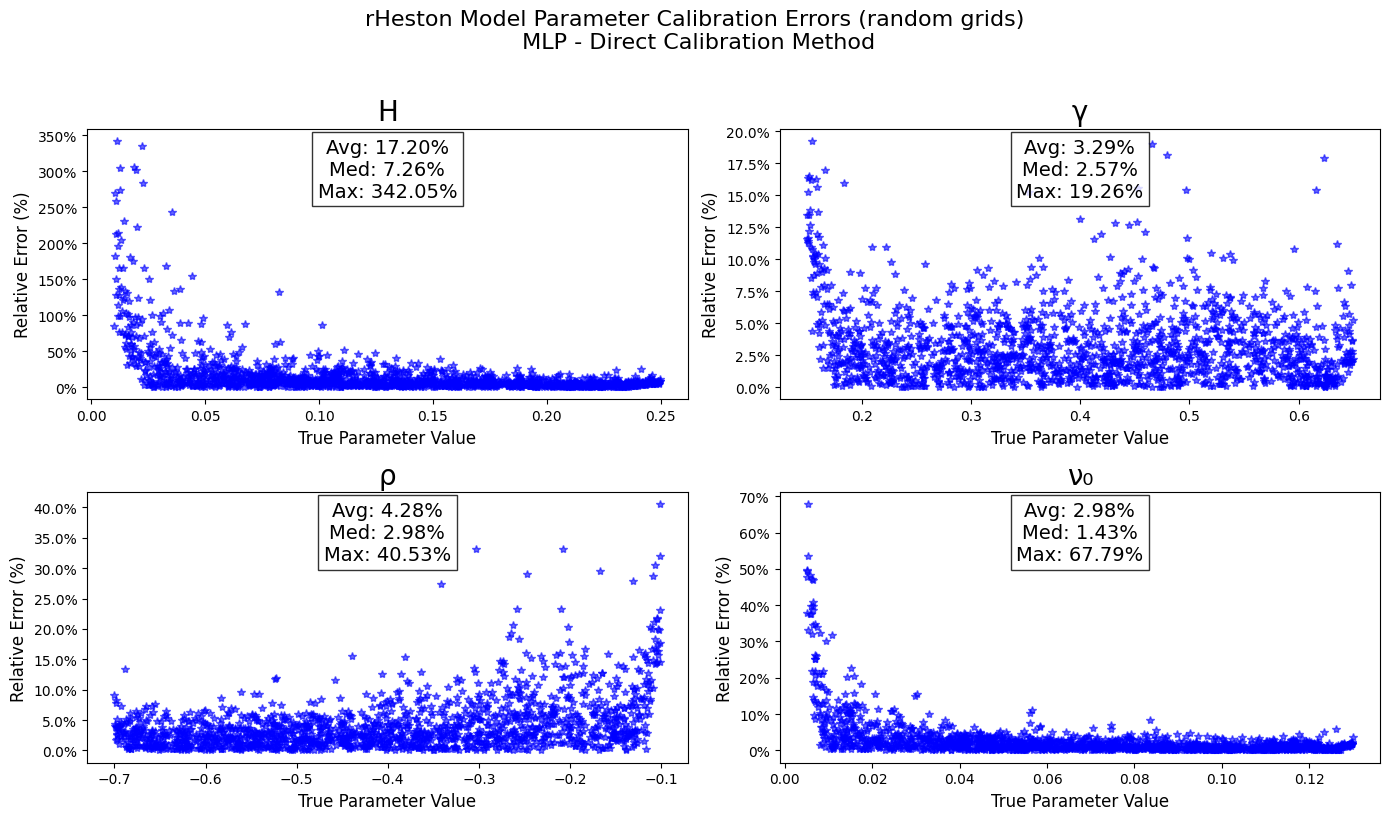


Summary Statistics of Relative Errors (%):
H: Avg=17.20%, Med=7.26%, Max=342.05%
γ: Avg=3.29%, Med=2.57%, Max=19.26%
ρ: Avg=4.28%, Med=2.98%, Max=40.53%
ν₀: Avg=2.98%, Med=1.43%, Max=67.79%


In [14]:
# Convert predictions to original scale
print(f"Surfaces parameters shape: {y_pred_transformed.shape}")  # Should be (1600,4)
calib_params = y_pred_original

# Verify dimensions
assert len(calib_params) == len(y_test_mlp), "Mismatch between calibrated parameters and test set"

# Plot relative errors for each parameter
titles = ["H", "γ", "ρ", "ν₀"]
relative_errors = np.zeros((len(calib_params), 4))  # Store all relative errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = y_test_mlp[:, param_idx]
    calibrated_params = calib_params[:, param_idx]
    
    # Calculate relative errors 
    with np.errstate(divide='ignore', invalid='ignore'):
        rel_errors = np.abs(calibrated_params - true_params) / np.abs(true_params)
    
    relative_errors[:, param_idx] = rel_errors
    
    # Plot
    plt.plot(true_params, 100 * rel_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Relative Error (%)', fontsize=12)
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
    
    # Add statistics
    stats_text = 'Avg: %1.2f%%\nMed: %1.2f%%\nMax: %1.2f%%' % (
        np.mean(100 * rel_errors),
        np.median(100 * rel_errors),
        np.max(100 * rel_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rHeston Model Parameter Calibration Errors (random grids)\n MLP - Direct Calibration Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Relative Errors (%):")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(100*relative_errors[:,i]):.2f}%, "
          f"Med={np.median(100*relative_errors[:,i]):.2f}%, "
          f"Max={np.max(100*relative_errors[:,i]):.2f}%")

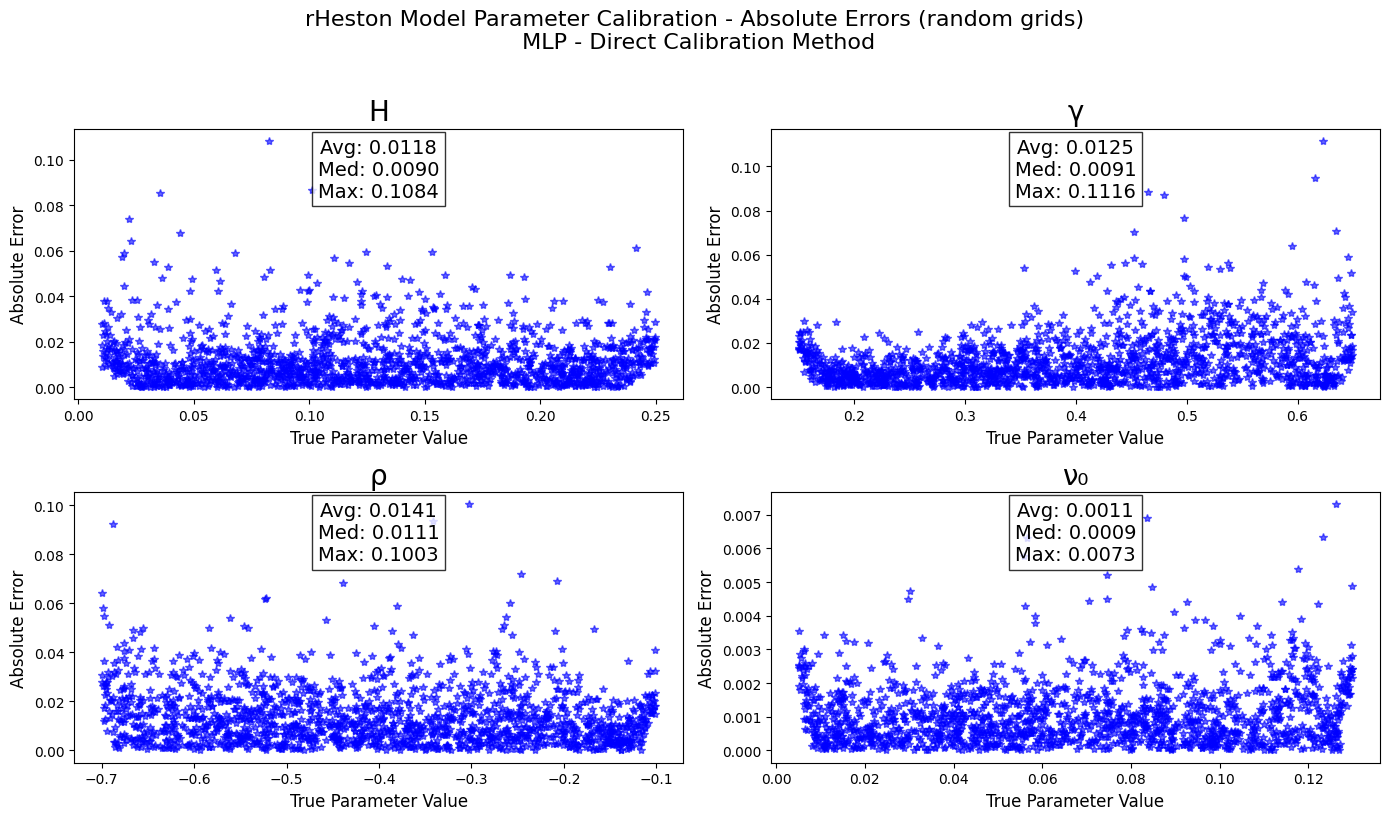


Summary Statistics of Absolute Errors:
H: Avg=0.011778, Med=0.009024, Max=0.108429
γ: Avg=0.012486, Med=0.009133, Max=0.111600
ρ: Avg=0.014066, Med=0.011149, Max=0.100350
ν₀: Avg=0.001089, Med=0.000883, Max=0.007313


In [15]:
# Correct parameter names and absolute error analysis
titles = ["H", "γ", "ρ", "ν₀"]
absolute_errors = np.zeros((len(calib_params), 4))  # Store all absolute errors

fig = plt.figure(figsize=(14, 8))
for param_idx in range(4):
    ax = plt.subplot(2, 2, param_idx+1)
    
    # Get true and calibrated parameters
    true_params = y_test_mlp[:, param_idx]
    calibrated_params = calib_params[:, param_idx]
    
    # Calculate absolute errors
    abs_errors = np.abs(calibrated_params - true_params)
    absolute_errors[:, param_idx] = abs_errors
    
    # Plot
    plt.plot(true_params, abs_errors, 'b*', alpha=0.6)
    plt.title(titles[param_idx], fontsize=20)
    plt.xlabel('True Parameter Value', fontsize=12)
    plt.ylabel('Absolute Error', fontsize=12)
    
    # Add statistics
    stats_text = 'Avg: %1.4f\nMed: %1.4f\nMax: %1.4f' % (
        np.mean(abs_errors),
        np.median(abs_errors),
        np.max(abs_errors))
    
    plt.text(0.5, 0.85, stats_text,
             horizontalalignment='center',
             verticalalignment='center',
             transform=ax.transAxes,
             fontsize=14,
             bbox=dict(facecolor='white', alpha=0.8))

plt.suptitle('rHeston Model Parameter Calibration - Absolute Errors (random grids)\n MLP - Direct Calibration Method', 
             fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

# Additional analysis
print("\nSummary Statistics of Absolute Errors:")
for i, title in enumerate(titles):
    print(f"{title}: Avg={np.mean(absolute_errors[:,i]):.6f}, "
          f"Med={np.median(absolute_errors[:,i]):.6f}, "
          f"Max={np.max(absolute_errors[:,i]):.6f}")

# Optimizing the calibration
Numpy Implementation of the Neural Network tends to be **faster** than Keras, in this way we can evaluate in a faster and more efficient way the calibration cutting further down the calibration time.

 In particular we completely **eliminate** the Keras framework **overhead** for each predict call. 

 The following numpy implementations are specifically designed for single and batch surfaces calibration, every operation is vectorized, the batch version processes **all the surfaces at once** completely in parallel leveraging preallocation for efficient memory usage. 
 
 This leads to a **~40** faster calibration: only few µs per surface!

In [20]:
import scipy.optimize
import matplotlib.ticker as mtick

def extract_weights_from_keras_model(model):
    """
    Extract weights and bias from the trained keras network, format for Numpy usage
    """
    weights_and_biases = []
    
    # Extract weights and biases for each layer
    for layer in model.layers:
        if hasattr(layer, 'get_weights') and layer.get_weights():
            weights, biases = layer.get_weights()
            weights_and_biases.append([weights, biases])
    
    return weights_and_biases

# Extract parameters from your trained model
NNParameters = extract_weights_from_keras_model(model_mlp)

# =====================================================================================
# NUMPY IMPLEMENTATION OF THE DIRECT CALIBRATION NN (FASTER THAN KERAS)
# =====================================================================================

# Network hyperparameters
NumLayers = 4  # 4 hidden layers (30 neurons each)
InputSize = 429  # 429 volatility surface points
OutputSize = 4  # 4 rHeston parameters

def elu(x):
    """
    ELU activation function
    Args:
        x: input array
    Returns:
        ELU activated array
    """
    x = np.array(x, dtype=np.float64)
    return np.where(x < 0, np.exp(x) - 1, x)

def DirectCalibrationNN(x):
    """
    Forward pass of Direct Calibration Neural Network
    
    Args:
        volatility_surfaces: arrays of 429 volatility surface points + strike + maturity (input)
    
    Returns:
        heston_params: array of 4 rHeston parameters 
    """
    # Forward pass through hidden layers with ELU activation
    for i in range(NumLayers):
        # Linear transformation: x = x * W + b
        x = np.dot(x, NNParameters[i][0]) + NNParameters[i][1]
        # ELU activation
        x = elu(x)
    
    # Output layer with tanh activation
    output = np.dot(x, NNParameters[NumLayers][0]) + NNParameters[NumLayers][1]
    output = np.tanh(output)
    
    return output

# =====================================================================================
# OPTIMIZED NUMPY IMPLEMENTATION FOR BATCH PROCESSING
# =====================================================================================

def batch_DirectCalibrationNN(volatility_surfaces):
    """
    Vectorized forward pass for batch processing
    
    Args:
        volatility_surfaces: array of shape (n_surfaces, 429) 
    Returns:
        rHeston_params: array of shape (n_surfaces, 4)
    """
    # Pre-allocate output array
    n_surfaces = volatility_surfaces.shape[0]
    output = np.zeros((n_surfaces, 4))
    
    # Batch processing through all layers
    x = volatility_surfaces.copy()
    for i in range(NumLayers):
        x = x @ NNParameters[i][0] + NNParameters[i][1]  # @ = matrix multiplication
        x = np.where(x < 0, np.exp(x) - 1, x)  # ELU activation
    
    # Output layer with tanh
    output = np.tanh(x @ NNParameters[NumLayers][0] + NNParameters[NumLayers][1])
    return output

# =====================================================================================
# BENCHMARKING OPTIMIZED VERSION
# =====================================================================================

def run_benchmark():
    # Warm-up runs (ensure fair timing)
    _ = batch_DirectCalibrationNN(X_test_mlp_transform[:10])
    
    # Time measurement
    start_time = time.perf_counter()
    calibrated_params = batch_DirectCalibrationNN(X_test_mlp_transform)
    total_time = (time.perf_counter() - start_time) * 1000  # Convert to ms
    
    n_surfaces = X_test_mlp_transform.shape[0]
    avg_time = total_time / n_surfaces
    
    print(f"\nBATCH CALIBRATION RESULTS (NumPy Optimized)")
    print("----------------------------------------")
    print(f"Total surfaces processed: {n_surfaces}")
    print(f"Total calibration time: {total_time:.2f} ms")
    print(f"Average time per surface: {avg_time*1000:.4f} µs")
    print(f"Throughput: {n_surfaces/(total_time/1000):.0f} surfaces/second")
    
    return calibrated_params

# Run benchmark
final_calibrated_params = run_benchmark()


BATCH CALIBRATION RESULTS (NumPy Optimized)
----------------------------------------
Total surfaces processed: 1600
Total calibration time: 7.40 ms
Average time per surface: 4.6239 µs
Throughput: 216266 surfaces/second
